# 1.1 Сравнение моделей разной глубины

Загрузчик датасетов

In [26]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm



class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader 

Создание модели по конфигурациям

In [27]:
import torch
import torch.nn as nn
import json

class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs

        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)

        self.layers = self._build_layers()

    def load_config(self, config_path):
        """
        Загружает конфигурацию из JSON файла
        """
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size

        layer_config = self.config.get('layers', [])

        for layer_spec in layer_config:
            layer_type = layer_spec['type']

            match layer_type:
                case 'linear':
                    out_size = layer_spec['size']
                    layers.append(nn.Linear(prev_size, out_size))
                    prev_size = out_size

                case 'relu':
                    layers.append(nn.ReLU())

                case 'sigmoid':
                    layers.append(nn.Sigmoid())

                case 'tanh':
                    layers.append(nn.Tanh())

                case 'dropout':
                    rate = layer_spec.get('rate', 0.5)
                    layers.append(nn.Dropout(rate))

                case 'batch_norm':
                    layers.append(nn.BatchNorm1d(prev_size))

                case 'layer_norm':
                    layers.append(nn.LayerNorm(prev_size))

                case _:
                    raise ValueError(f"Неизвестный тип слоя: {layer_type}")

        # Всегда добавляем финальный слой для классификации
        layers.append(nn.Linear(prev_size, self.num_classes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # "выпрямляем" картинку в вектор
        return self.layers(x)

Наборы конфигураций

In [28]:

# Мне удобнее словарь создать, чем под каждую новую модель создавать json с конфигами
# 1 слой (линейный классификатор)
config_1_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers":[]
}
# 2 слоя (1 скрытый)
config_2_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers":[
        {"type":"linear", "size": 512},
        {"type":"relu"},
        {"type":"dropout", "rate": 0.4}
    ]
}

# 3 слоя (2 скрытых)
config_3_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}
# 5 слоев (4 скрытых)
config_5_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "batch_norm"},
        
        {"type": "linear", "size": 128},
        {"type": "relu"},
        {"type": "batch_norm"},
        
        {"type": "linear", "size": 64},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}
# 7 слоев (6 скрытых)
config_7_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "batch_norm"},
        
        {"type": "linear", "size": 128},
        {"type": "relu"},
        {"type": "batch_norm"},
        
        {"type": "linear", "size": 64},
        {"type": "relu"},
        {"type": "batch_norm"},
        
        {"type": "linear", "size": 32},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}

# model_3_layer = FullyConnectedModel(config_path=None, **config_3_layer)
# print(model_3_layer)

Обучение модели

In [29]:
def run_epoch(model, data_loader, criterion, optimizer = None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

Создание графиков и Сохранение/загрузка модели

In [30]:
import torch
import matplotlib.pyplot as plt
import os

def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()
    
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()
    
    plt.tight_layout()


def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_model(
        path: str, 
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        epoch: int, 
        best_test_loss: float, 
        best_test_acc: float
    ):
    state_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'best_test_loss': best_test_loss,
        'best_test_acc': best_test_acc
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state_dict, path)


def load_model(path: str, model: torch.nn.Module, optimizer: torch.optim.Optimizer):
    state_dict = torch.load(path)
    model.load_state_dict(state_dict['model'])
    optimizer.load_state_dict(state_dict['optimizer'])
    return state_dict['epoch'], state_dict['best_test_loss'], state_dict['best_test_acc']

Запускаем модель (1 слой)

Model parameters: 7850


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.54it/s]


Epoch 1/10:
Train Loss: 0.3956, Train Acc: 0.8878
Test Loss: 0.2921, Test Acc: 0.9158
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.32it/s]


Epoch 2/10:
Train Loss: 0.2962, Train Acc: 0.9151
Test Loss: 0.2771, Test Acc: 0.9204
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.21it/s]


Epoch 3/10:
Train Loss: 0.2821, Train Acc: 0.9202
Test Loss: 0.2789, Test Acc: 0.9218
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.69it/s]


Epoch 4/10:
Train Loss: 0.2752, Train Acc: 0.9228
Test Loss: 0.2829, Test Acc: 0.9201
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.96it/s]


Epoch 5/10:
Train Loss: 0.2719, Train Acc: 0.9243
Test Loss: 0.2776, Test Acc: 0.9246
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.60it/s]


Epoch 6/10:
Train Loss: 0.2681, Train Acc: 0.9248
Test Loss: 0.2734, Test Acc: 0.9240
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.92it/s]


Epoch 7/10:
Train Loss: 0.2644, Train Acc: 0.9258
Test Loss: 0.2745, Test Acc: 0.9230
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.68it/s]


Epoch 8/10:
Train Loss: 0.2640, Train Acc: 0.9260
Test Loss: 0.2840, Test Acc: 0.9222
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.75it/s]


Epoch 9/10:
Train Loss: 0.2613, Train Acc: 0.9267
Test Loss: 0.2720, Test Acc: 0.9248
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.76it/s]


Epoch 10/10:
Train Loss: 0.2600, Train Acc: 0.9276
Test Loss: 0.2698, Test Acc: 0.9256
--------------------------------------------------
{'train_losses': [0.39555358309259037, 0.2961930768417397, 0.28213313273164126, 0.27519293673940176, 0.2718540803590881, 0.2680918966560984, 0.26444362696490564, 0.26403443114176744, 0.2612568953358479, 0.2600426949989567], 'train_accs': [0.8877833333333334, 0.91505, 0.9202, 0.9228333333333333, 0.9242833333333333, 0.9248166666666666, 0.9257833333333333, 0.9259833333333334, 0.9266833333333333, 0.9276], 'test_losses': [0.29208731322673853, 0.27706936819205996, 0.2788578581337811, 0.28286645055457854, 0.2775812239214114, 0.273378424364243, 0.27453975480310855, 0.2839607444597752, 0.2719626027177189, 0.2697811060863885], 'test_accs': [0.9158, 0.9204, 0.9218, 0.9201, 0.9246, 0.924, 0.923, 0.9222, 0.9248, 0.9256]}
333.35645270347595


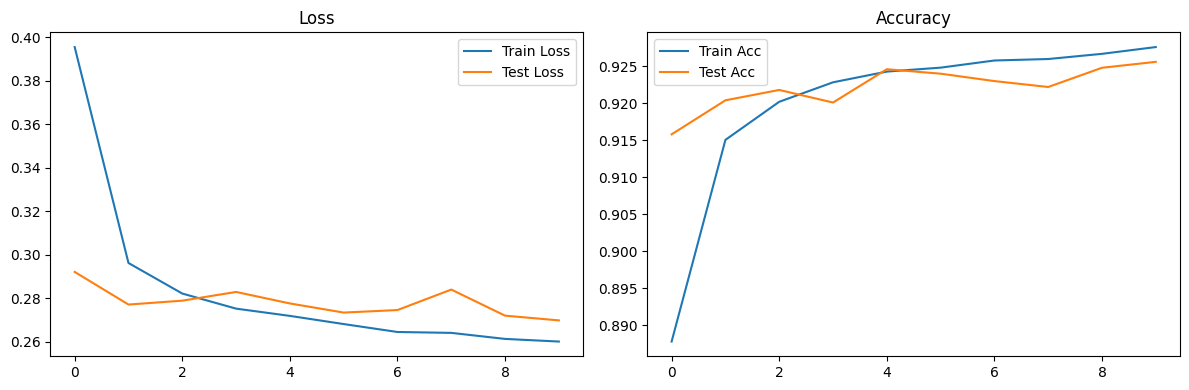

In [31]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_mnist_loaders(batch_size=64)

#Выбираем один из наборов конфигураций модели
model = FullyConnectedModel(config_path=None, **config_1_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель 2 слоя

Model parameters: 407050


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.63it/s]


Epoch 1/10:
Train Loss: 0.2538, Train Acc: 0.9225
Test Loss: 0.1097, Test Acc: 0.9682
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.32it/s]


Epoch 2/10:
Train Loss: 0.1291, Train Acc: 0.9618
Test Loss: 0.0868, Test Acc: 0.9730
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.10it/s]


Epoch 3/10:
Train Loss: 0.1009, Train Acc: 0.9691
Test Loss: 0.0750, Test Acc: 0.9756
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.39it/s]


Epoch 4/10:
Train Loss: 0.0882, Train Acc: 0.9722
Test Loss: 0.0715, Test Acc: 0.9786
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.30it/s]


Epoch 5/10:
Train Loss: 0.0786, Train Acc: 0.9749
Test Loss: 0.0664, Test Acc: 0.9793
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.92it/s]


Epoch 6/10:
Train Loss: 0.0695, Train Acc: 0.9783
Test Loss: 0.0668, Test Acc: 0.9806
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.03it/s]


Epoch 7/10:
Train Loss: 0.0641, Train Acc: 0.9795
Test Loss: 0.0754, Test Acc: 0.9784
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.00it/s]


Epoch 8/10:
Train Loss: 0.0646, Train Acc: 0.9795
Test Loss: 0.0726, Test Acc: 0.9805
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.28it/s]


Epoch 9/10:
Train Loss: 0.0558, Train Acc: 0.9823
Test Loss: 0.0708, Test Acc: 0.9814
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.72it/s]


Epoch 10/10:
Train Loss: 0.0543, Train Acc: 0.9826
Test Loss: 0.0762, Test Acc: 0.9794
--------------------------------------------------
{'train_losses': [0.2538228468226789, 0.12911679935472797, 0.10089844323571588, 0.08815303316681401, 0.07864961135404697, 0.06953889370470473, 0.06412064804517324, 0.06456113692066734, 0.0558239611991143, 0.054315173472992695], 'train_accs': [0.92255, 0.9618166666666667, 0.9690666666666666, 0.9722166666666666, 0.9749166666666667, 0.9782833333333333, 0.9795333333333334, 0.9794833333333334, 0.9823333333333333, 0.9826333333333334], 'test_losses': [0.10973472403107318, 0.0867658891910865, 0.07495234472618534, 0.07146969010502788, 0.06637153277586746, 0.06681239047226946, 0.07542898513878707, 0.07263648944889187, 0.0708291404234509, 0.07620623146051153], 'test_accs': [0.9682, 0.973, 0.9756, 0.9786, 0.9793, 0.9806, 0.9784, 0.9805, 0.9814, 0.9794]}
410.2735974788666


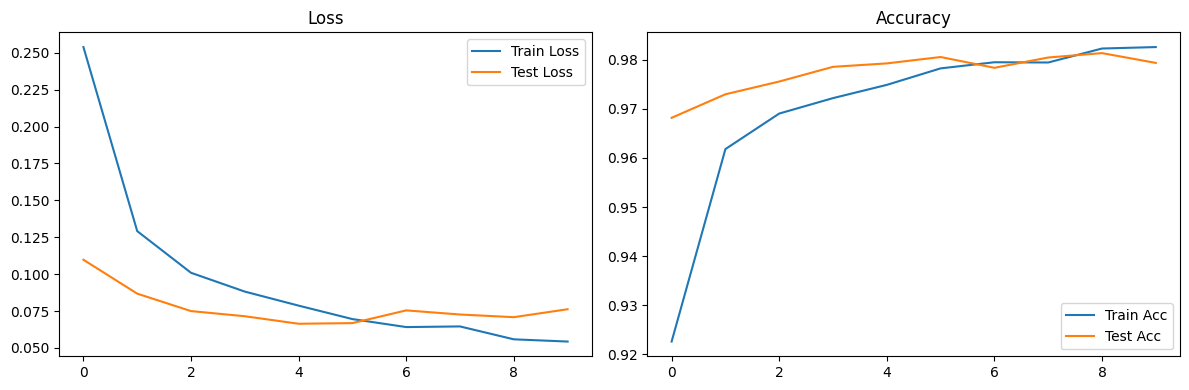

In [32]:
model = FullyConnectedModel(config_path=None, **config_2_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель 3 слоя

Model parameters: 536842


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.75it/s]


Epoch 1/10:
Train Loss: 0.2202, Train Acc: 0.9331
Test Loss: 0.1044, Test Acc: 0.9682
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.50it/s]


Epoch 2/10:
Train Loss: 0.1163, Train Acc: 0.9639
Test Loss: 0.0837, Test Acc: 0.9734
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.17it/s]


Epoch 3/10:
Train Loss: 0.0884, Train Acc: 0.9727
Test Loss: 0.0977, Test Acc: 0.9737
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.63it/s]


Epoch 4/10:
Train Loss: 0.0743, Train Acc: 0.9768
Test Loss: 0.0902, Test Acc: 0.9753
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.30it/s]


Epoch 5/10:
Train Loss: 0.0646, Train Acc: 0.9790
Test Loss: 0.1418, Test Acc: 0.9794
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.34it/s]


Epoch 6/10:
Train Loss: 0.0573, Train Acc: 0.9818
Test Loss: 0.1061, Test Acc: 0.9783
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.11it/s]


Epoch 7/10:
Train Loss: 0.0489, Train Acc: 0.9841
Test Loss: 0.1325, Test Acc: 0.9770
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.37it/s]


Epoch 8/10:
Train Loss: 0.0466, Train Acc: 0.9845
Test Loss: 0.0852, Test Acc: 0.9790
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.42it/s]


Epoch 9/10:
Train Loss: 0.0415, Train Acc: 0.9862
Test Loss: 0.1005, Test Acc: 0.9805
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.60it/s]


Epoch 10/10:
Train Loss: 0.0364, Train Acc: 0.9882
Test Loss: 0.1473, Test Acc: 0.9769
--------------------------------------------------
{'train_losses': [0.22021038036968218, 0.11632332157915526, 0.08840436944966393, 0.07426177543589968, 0.06461218717646525, 0.05728183781131427, 0.048914376239571324, 0.04661914716109332, 0.04147619185406394, 0.03642615732725219], 'train_accs': [0.9331166666666667, 0.96395, 0.9726833333333333, 0.97685, 0.97905, 0.98175, 0.9840833333333333, 0.9844833333333334, 0.9862, 0.9881666666666666], 'test_losses': [0.10435159544899443, 0.08371033314926918, 0.09765151109780737, 0.09018796993036544, 0.14182102808898062, 0.10608202753738989, 0.1325332824515638, 0.08523513788297965, 0.1005462983179383, 0.14726472364215687], 'test_accs': [0.9682, 0.9734, 0.9737, 0.9753, 0.9794, 0.9783, 0.977, 0.979, 0.9805, 0.9769]}
427.5516791343689


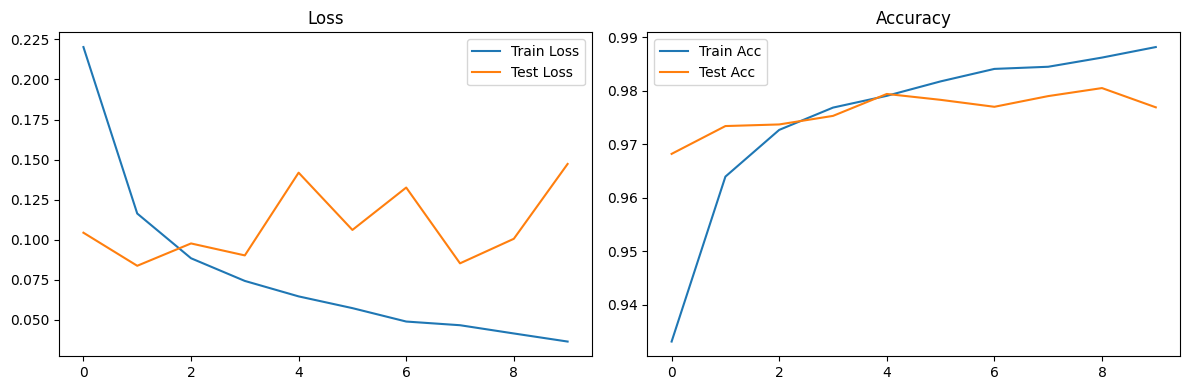

In [33]:
model = FullyConnectedModel(config_path=None, **config_3_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель 5 слоев

Model parameters: 576842


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.58it/s]


Epoch 1/10:
Train Loss: 0.2922, Train Acc: 0.9215
Test Loss: 0.1071, Test Acc: 0.9677
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.15it/s]


Epoch 2/10:
Train Loss: 0.1436, Train Acc: 0.9601
Test Loss: 0.0973, Test Acc: 0.9713
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.50it/s]


Epoch 3/10:
Train Loss: 0.1114, Train Acc: 0.9689
Test Loss: 0.1130, Test Acc: 0.9685
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.51it/s]


Epoch 4/10:
Train Loss: 0.0943, Train Acc: 0.9735
Test Loss: 0.0904, Test Acc: 0.9758
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.27it/s]


Epoch 5/10:
Train Loss: 0.0781, Train Acc: 0.9781
Test Loss: 0.1120, Test Acc: 0.9776
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.84it/s]


Epoch 6/10:
Train Loss: 0.0680, Train Acc: 0.9804
Test Loss: 0.1251, Test Acc: 0.9798
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.57it/s]


Epoch 7/10:
Train Loss: 0.0616, Train Acc: 0.9821
Test Loss: 0.1435, Test Acc: 0.9777
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.26it/s]


Epoch 8/10:
Train Loss: 0.0548, Train Acc: 0.9840
Test Loss: 0.1013, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.64it/s]


Epoch 9/10:
Train Loss: 0.0519, Train Acc: 0.9845
Test Loss: 0.1038, Test Acc: 0.9785
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.52it/s]


Epoch 10/10:
Train Loss: 0.0452, Train Acc: 0.9868
Test Loss: 0.1135, Test Acc: 0.9803
--------------------------------------------------
{'train_losses': [0.2921700980256139, 0.1436441884741489, 0.11136577307367757, 0.09430617632876549, 0.07811887146481104, 0.06799560333197531, 0.06164946816978293, 0.05484956800183063, 0.051918950193546226, 0.04516330033851994], 'train_accs': [0.92155, 0.9600666666666666, 0.96895, 0.9734833333333334, 0.9781, 0.9803833333333334, 0.9820666666666666, 0.98405, 0.9845333333333334, 0.9867833333333333], 'test_losses': [0.10713263722448046, 0.09730813341014306, 0.11300140841505164, 0.09036700554523146, 0.11196279552075411, 0.12505520560647895, 0.14353063443957778, 0.10134720187986905, 0.10376532947436323, 0.11349743763108494], 'test_accs': [0.9677, 0.9713, 0.9685, 0.9758, 0.9776, 0.9798, 0.9777, 0.9797, 0.9785, 0.9803]}
443.3716022968292


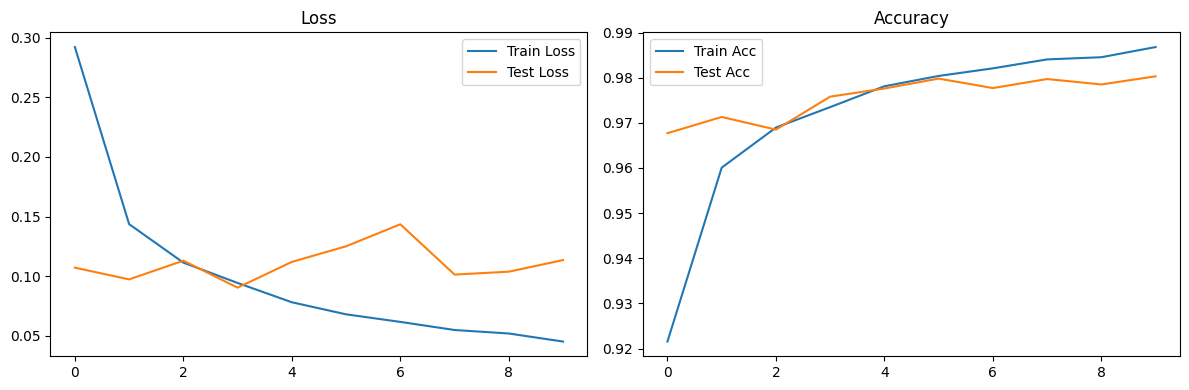

In [35]:
model = FullyConnectedModel(config_path=None, **config_5_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель 7 слоев

Model parameters: 578730


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.84it/s]


Epoch 1/10:
Train Loss: 0.4060, Train Acc: 0.9002
Test Loss: 0.1733, Test Acc: 0.9509
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.08it/s]


Epoch 2/10:
Train Loss: 0.1977, Train Acc: 0.9509
Test Loss: 0.1084, Test Acc: 0.9685
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.86it/s]


Epoch 3/10:
Train Loss: 0.1482, Train Acc: 0.9619
Test Loss: 0.1096, Test Acc: 0.9698
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.20it/s]


Epoch 4/10:
Train Loss: 0.1312, Train Acc: 0.9658
Test Loss: 0.1020, Test Acc: 0.9760
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.80it/s]


Epoch 5/10:
Train Loss: 0.1134, Train Acc: 0.9714
Test Loss: 0.0928, Test Acc: 0.9790
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.01it/s]


Epoch 6/10:
Train Loss: 0.0964, Train Acc: 0.9749
Test Loss: 0.0860, Test Acc: 0.9760
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.57it/s]


Epoch 7/10:
Train Loss: 0.0900, Train Acc: 0.9763
Test Loss: 0.0924, Test Acc: 0.9779
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.56it/s]


Epoch 8/10:
Train Loss: 0.0808, Train Acc: 0.9796
Test Loss: 0.0813, Test Acc: 0.9807
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.25it/s]


Epoch 9/10:
Train Loss: 0.0772, Train Acc: 0.9793
Test Loss: 0.1211, Test Acc: 0.9809
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.81it/s]


Epoch 10/10:
Train Loss: 0.0701, Train Acc: 0.9815
Test Loss: 0.1125, Test Acc: 0.9805
--------------------------------------------------
{'train_losses': [0.40604781966680276, 0.1976617493593235, 0.1481702112064544, 0.1311784754730642, 0.11344550230822313, 0.09636052463626636, 0.08996640622014128, 0.08075109316777787, 0.0772220292354503, 0.07006879958179174], 'train_accs': [0.9002, 0.9509166666666666, 0.9618666666666666, 0.9658333333333333, 0.9714166666666667, 0.9749333333333333, 0.9762666666666666, 0.97955, 0.9793166666666666, 0.9814833333333334], 'test_losses': [0.17327843896546372, 0.10837936429025095, 0.10961167528069723, 0.10204198626133282, 0.09284622342252338, 0.08601981273907994, 0.09243568344954027, 0.08131361058890926, 0.12107636822415799, 0.11246137034764024], 'test_accs': [0.9509, 0.9685, 0.9698, 0.976, 0.979, 0.976, 0.9779, 0.9807, 0.9809, 0.9805]}
460.76598143577576


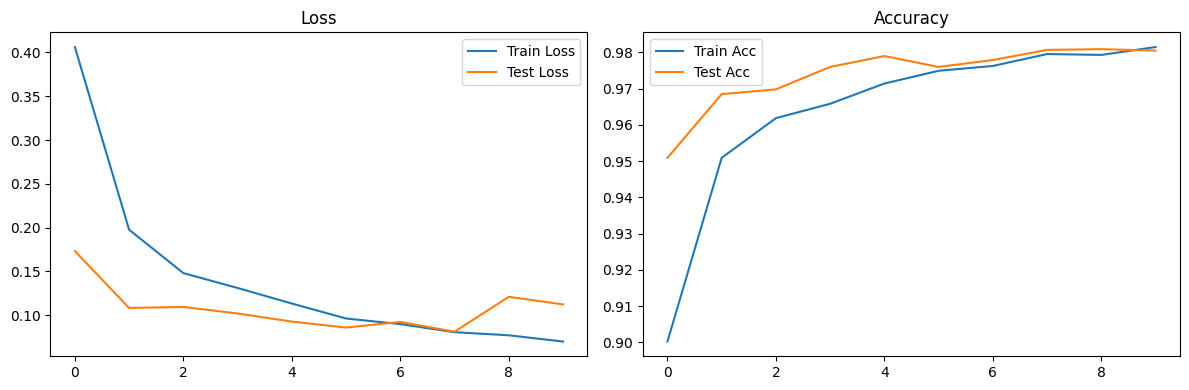

In [36]:
model = FullyConnectedModel(config_path=None, **config_7_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

# Анализ вывода
Смотря по выводам параметров на обучающей выборке на каждой эпохе можно заметиить, что с количеством эпох улучшается результат параметров. Однако тестовые дают плохие результаты, парметры показывают что идет переобучение. Это касается абсолютно всех моделей. 

Теперь проанализируем каждую модель.
## 1 слой
Модель с 1-им слоем показывает не плохой результат. Параметры скачут и показывают, что модель возможно переобучилась. Тренировочные и тестовые в начале мало чем отличаются, но заметны большой разброс у тестовых данных. Можно сказать, что в начале модель шалила, а потом начала нормализовываться. 
## 2 слоя
Модель с 2-мя слоями показывает похуже, графики не скачут и идут примерно равномерно, однако под конец accuracy начинает
падать, а ошибка расти, это показывает на то что модель скорее всего переобучилась. 
## 3 слоя
Модель с 3-мя слоями явно показывает на то, что она переобучилась. Графики идут не равномерно, под конец графики показывают что праметры точно становятся хуже (хотя у accuracy не так сильно плозо как у loss, но все равно плохо)
## 5 слоев
Модель с 5-ю слоями результат крайне похож на модель с 3-мя слоями. Также равномерно идет, но под конец ошибка значительно увеличилась. Accuracy начинает нормализовываться, но не факт, возомжно кратковременное поднятие в конце, с увеличением эпох скорее всего будет падать. 
## 7 слоев
Модель с 7-ю слоями в плане ошибки показывает плохой, у этой модели особенно отчетливо виден рост ошибки с увеличением эпохи. А вот Accuracy наоборот, более менее хороший результат, однако в конце заметно падение, но возможно кратковременно. Я бы не исключал что модель переобучилась

Если говорить о времени, она незначительно, но растет в зависимости от количества слоев, модель с 1 слоев показывает скорость лучше всех. 

# 1.2 Анализ переобучения


Под данный пункт а уже на половину заданий уже ответил или уже провел. Dropout и BatchNorm особо не улучшают результат. 
Сейчас ниже я сделаю config без нормализации и отключения весов

In [37]:
# 1 слой (линейный классификатор)
config_1_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers":[]
}
# 2 слоя (1 скрытый)
config_2_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers":[
        {"type":"linear", "size": 512},
        {"type":"relu"},
    ]
}

# 3 слоя (2 скрытых)
config_3_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
    ]
}
# 5 слоев (4 скрытых)
config_5_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        
        {"type": "linear", "size": 128},
        {"type": "relu"},
        
        {"type": "linear", "size": 64},
        {"type": "relu"},
    ]
}
# 7 слоев (6 скрытых)
config_7_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        
        {"type": "linear", "size": 128},
        {"type": "relu"},
        
        {"type": "linear", "size": 64},
        {"type": "relu"},
        
        {"type": "linear", "size": 32},
        {"type": "relu"},
    ]
}

# model_3_layer = FullyConnectedModel(config_path=None, **config_3_layer)
# print(model_3_layer)

1

Model parameters: 7850


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 39.22it/s]


Epoch 1/10:
Train Loss: 0.3945, Train Acc: 0.8883
Test Loss: 0.2948, Test Acc: 0.9145
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.79it/s]


Epoch 2/10:
Train Loss: 0.2938, Train Acc: 0.9173
Test Loss: 0.2916, Test Acc: 0.9151
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.39it/s]


Epoch 3/10:
Train Loss: 0.2814, Train Acc: 0.9201
Test Loss: 0.2790, Test Acc: 0.9216
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.35it/s]


Epoch 4/10:
Train Loss: 0.2762, Train Acc: 0.9223
Test Loss: 0.2813, Test Acc: 0.9192
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.27it/s]


Epoch 5/10:
Train Loss: 0.2712, Train Acc: 0.9235
Test Loss: 0.2788, Test Acc: 0.9236
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.89it/s]


Epoch 6/10:
Train Loss: 0.2681, Train Acc: 0.9245
Test Loss: 0.2822, Test Acc: 0.9182
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.26it/s]


Epoch 7/10:
Train Loss: 0.2669, Train Acc: 0.9254
Test Loss: 0.2725, Test Acc: 0.9253
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 19.64it/s]


Epoch 8/10:
Train Loss: 0.2624, Train Acc: 0.9277
Test Loss: 0.2836, Test Acc: 0.9190
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.15it/s]


Epoch 9/10:
Train Loss: 0.2620, Train Acc: 0.9266
Test Loss: 0.2814, Test Acc: 0.9216
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 38.72it/s]


Epoch 10/10:
Train Loss: 0.2588, Train Acc: 0.9276
Test Loss: 0.2836, Test Acc: 0.9232
--------------------------------------------------
{'train_losses': [0.3945234458107176, 0.29376048519651393, 0.28138433693489157, 0.27618462736926863, 0.27117228402353044, 0.26812219479953303, 0.26692296050266545, 0.26238164173832323, 0.2619908217356594, 0.2587677491808942], 'train_accs': [0.8882833333333333, 0.9172666666666667, 0.9200833333333334, 0.9223333333333333, 0.9235333333333333, 0.9245166666666667, 0.9253666666666667, 0.92775, 0.92665, 0.9276333333333333], 'test_losses': [0.2948185784065989, 0.2916014038358524, 0.27897941440367585, 0.2813212803096338, 0.2787748115125355, 0.2822147608930423, 0.27253471099575804, 0.2836250202125235, 0.28135643003710137, 0.28359000185492694], 'test_accs': [0.9145, 0.9151, 0.9216, 0.9192, 0.9236, 0.9182, 0.9253, 0.919, 0.9216, 0.9232]}
348.70622849464417


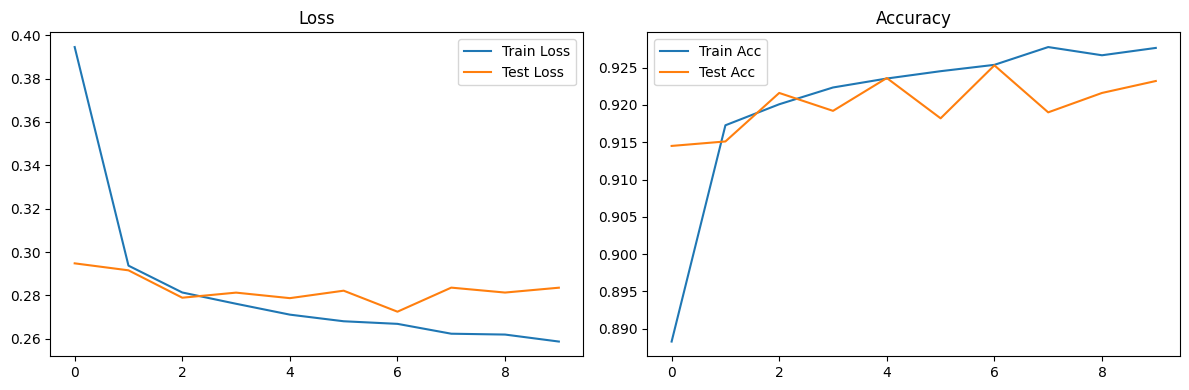

In [38]:
model = FullyConnectedModel(config_path=None, **config_1_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

2

Model parameters: 407050


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.57it/s]


Epoch 1/10:
Train Loss: 0.2027, Train Acc: 0.9388
Test Loss: 0.1056, Test Acc: 0.9667
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.88it/s]


Epoch 2/10:
Train Loss: 0.0837, Train Acc: 0.9743
Test Loss: 0.0800, Test Acc: 0.9759
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.96it/s]


Epoch 3/10:
Train Loss: 0.0564, Train Acc: 0.9824
Test Loss: 0.0686, Test Acc: 0.9788
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.81it/s]


Epoch 4/10:
Train Loss: 0.0420, Train Acc: 0.9862
Test Loss: 0.0819, Test Acc: 0.9757
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.00it/s]


Epoch 5/10:
Train Loss: 0.0308, Train Acc: 0.9897
Test Loss: 0.0739, Test Acc: 0.9775
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.18it/s]


Epoch 6/10:
Train Loss: 0.0269, Train Acc: 0.9909
Test Loss: 0.0781, Test Acc: 0.9782
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.63it/s]


Epoch 7/10:
Train Loss: 0.0231, Train Acc: 0.9923
Test Loss: 0.0791, Test Acc: 0.9807
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.71it/s]


Epoch 8/10:
Train Loss: 0.0220, Train Acc: 0.9923
Test Loss: 0.0852, Test Acc: 0.9784
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.05it/s]


Epoch 9/10:
Train Loss: 0.0169, Train Acc: 0.9944
Test Loss: 0.0997, Test Acc: 0.9752
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.84it/s]


Epoch 10/10:
Train Loss: 0.0148, Train Acc: 0.9949
Test Loss: 0.0849, Test Acc: 0.9824
--------------------------------------------------
{'train_losses': [0.2027290858038421, 0.0836722186656355, 0.05644237617952134, 0.04200886984192915, 0.03077200222565586, 0.026936298187398018, 0.02305866240662821, 0.02202947137940238, 0.01689264194860281, 0.014757284294875663], 'train_accs': [0.9388, 0.9742666666666666, 0.9823833333333334, 0.9861833333333333, 0.9897333333333334, 0.9909333333333333, 0.9923, 0.9922666666666666, 0.9944, 0.9949166666666667], 'test_losses': [0.10560680854365609, 0.08002394583550057, 0.06855925322966509, 0.08188939824850323, 0.07385477187576986, 0.07809857819816539, 0.07905239906824228, 0.08521750596916898, 0.09965086645376924, 0.08488022108206093], 'test_accs': [0.9667, 0.9759, 0.9788, 0.9757, 0.9775, 0.9782, 0.9807, 0.9784, 0.9752, 0.9824]}
374.2714464664459


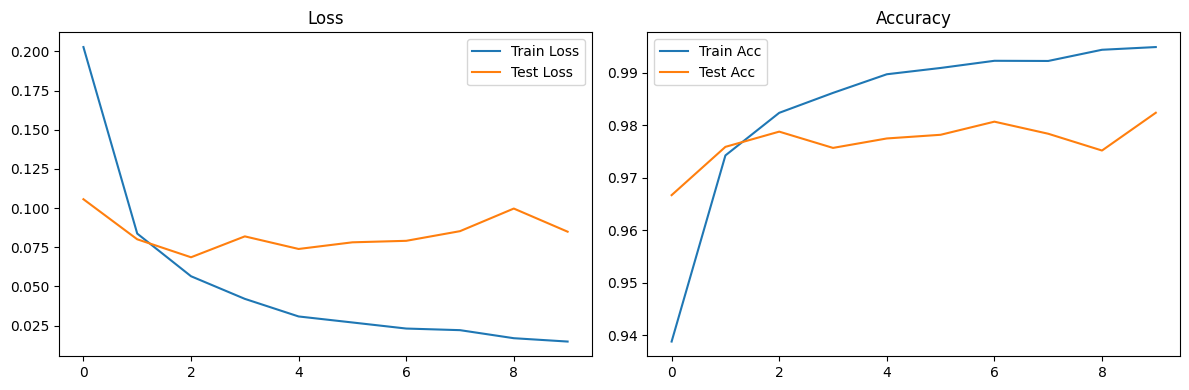

In [39]:
model = FullyConnectedModel(config_path=None, **config_2_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

3

Model parameters: 535818


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.58it/s]


Epoch 1/10:
Train Loss: 0.2056, Train Acc: 0.9368
Test Loss: 0.1235, Test Acc: 0.9619
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.89it/s]


Epoch 2/10:
Train Loss: 0.0859, Train Acc: 0.9730
Test Loss: 0.0853, Test Acc: 0.9740
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.51it/s]


Epoch 3/10:
Train Loss: 0.0603, Train Acc: 0.9806
Test Loss: 0.0652, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.67it/s]


Epoch 4/10:
Train Loss: 0.0454, Train Acc: 0.9853
Test Loss: 0.0681, Test Acc: 0.9800
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.51it/s]


Epoch 5/10:
Train Loss: 0.0387, Train Acc: 0.9875
Test Loss: 0.0744, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.67it/s]


Epoch 6/10:
Train Loss: 0.0315, Train Acc: 0.9896
Test Loss: 0.0964, Test Acc: 0.9755
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.82it/s]


Epoch 7/10:
Train Loss: 0.0276, Train Acc: 0.9914
Test Loss: 0.0880, Test Acc: 0.9793
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.78it/s]


Epoch 8/10:
Train Loss: 0.0237, Train Acc: 0.9918
Test Loss: 0.0847, Test Acc: 0.9792
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.89it/s]


Epoch 9/10:
Train Loss: 0.0226, Train Acc: 0.9926
Test Loss: 0.1101, Test Acc: 0.9751
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.05it/s]


Epoch 10/10:
Train Loss: 0.0211, Train Acc: 0.9938
Test Loss: 0.0940, Test Acc: 0.9809
--------------------------------------------------
{'train_losses': [0.2055746558120351, 0.08590040537096791, 0.060310728817697626, 0.04540286614674517, 0.03869400788382166, 0.0314915884612893, 0.027627525150641156, 0.023664171203641025, 0.022596509108323882, 0.021056216323212557], 'train_accs': [0.93685, 0.97305, 0.9805833333333334, 0.9852666666666666, 0.9874833333333334, 0.9896166666666667, 0.9914166666666666, 0.9918166666666667, 0.9925833333333334, 0.9938], 'test_losses': [0.12346609955902692, 0.08528142338574146, 0.06524372504400104, 0.06807015017030915, 0.07443937810775, 0.09640574359779348, 0.0880020845607198, 0.08474818478564242, 0.11011276854911256, 0.09397446081013235], 'test_accs': [0.9619, 0.974, 0.9797, 0.98, 0.9797, 0.9755, 0.9793, 0.9792, 0.9751, 0.9809]}
420.86237049102783


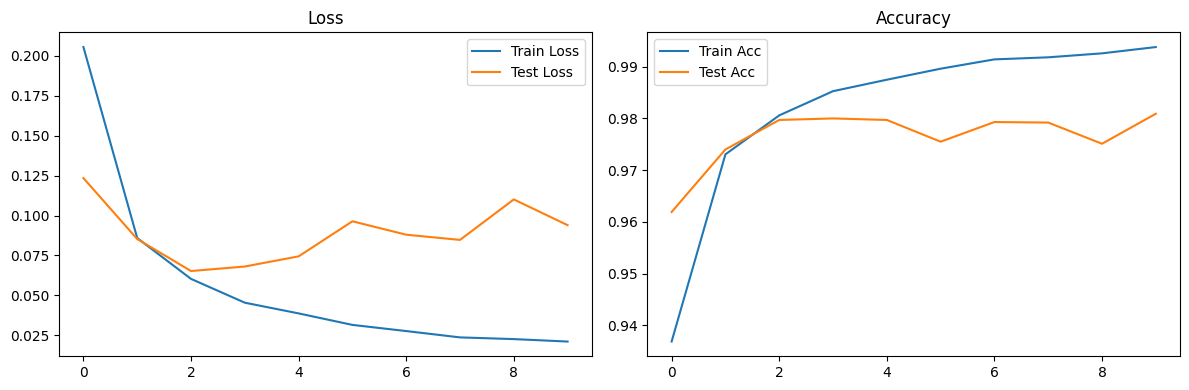

In [40]:
model = FullyConnectedModel(config_path=None, **config_3_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

5

Model parameters: 575050


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.06it/s]


Epoch 1/10:
Train Loss: 0.2495, Train Acc: 0.9244
Test Loss: 0.1031, Test Acc: 0.9693
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.49it/s]


Epoch 2/10:
Train Loss: 0.1031, Train Acc: 0.9690
Test Loss: 0.0996, Test Acc: 0.9714
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.83it/s]


Epoch 3/10:
Train Loss: 0.0715, Train Acc: 0.9784
Test Loss: 0.0855, Test Acc: 0.9740
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.30it/s]


Epoch 4/10:
Train Loss: 0.0570, Train Acc: 0.9827
Test Loss: 0.0725, Test Acc: 0.9773
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 26.02it/s]


Epoch 5/10:
Train Loss: 0.0467, Train Acc: 0.9859
Test Loss: 0.0820, Test Acc: 0.9783
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.64it/s]


Epoch 6/10:
Train Loss: 0.0398, Train Acc: 0.9876
Test Loss: 0.0730, Test Acc: 0.9811
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.63it/s]


Epoch 7/10:
Train Loss: 0.0348, Train Acc: 0.9889
Test Loss: 0.1032, Test Acc: 0.9748
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.46it/s]


Epoch 8/10:
Train Loss: 0.0293, Train Acc: 0.9908
Test Loss: 0.0844, Test Acc: 0.9805
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.79it/s]


Epoch 9/10:
Train Loss: 0.0269, Train Acc: 0.9917
Test Loss: 0.0747, Test Acc: 0.9818
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.14it/s]


Epoch 10/10:
Train Loss: 0.0228, Train Acc: 0.9928
Test Loss: 0.0842, Test Acc: 0.9785
--------------------------------------------------
{'train_losses': [0.2495283660437189, 0.10305367125970706, 0.07148428385415033, 0.05698002708953188, 0.04667981078957212, 0.039832953209884524, 0.03477265716959245, 0.029250307600815664, 0.02692871770096181, 0.022789498875144438], 'train_accs': [0.9243833333333333, 0.969, 0.9784333333333334, 0.9827333333333333, 0.9858833333333333, 0.9876, 0.98885, 0.9908, 0.99165, 0.9927666666666667], 'test_losses': [0.10306703452255198, 0.09963494927250145, 0.0854558464129319, 0.07247452710489713, 0.08201900688853674, 0.0730283400198633, 0.1032100294111037, 0.08444997638790558, 0.07467005173836529, 0.08421758095640369], 'test_accs': [0.9693, 0.9714, 0.974, 0.9773, 0.9783, 0.9811, 0.9748, 0.9805, 0.9818, 0.9785]}
490.51571011543274


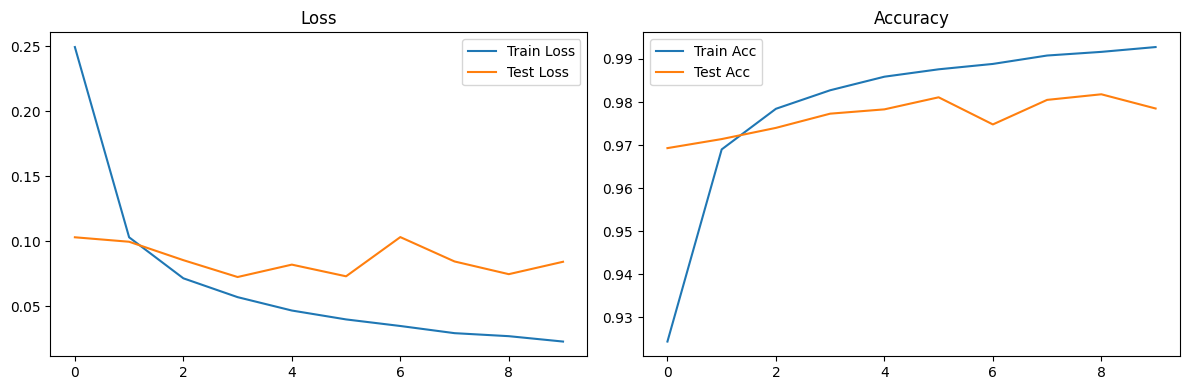

In [41]:
model = FullyConnectedModel(config_path=None, **config_5_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

7

Model parameters: 576810


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.47it/s]


Epoch 1/10:
Train Loss: 0.3070, Train Acc: 0.9031
Test Loss: 0.1252, Test Acc: 0.9610
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.04it/s]


Epoch 2/10:
Train Loss: 0.1093, Train Acc: 0.9681
Test Loss: 0.1011, Test Acc: 0.9686
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.49it/s]


Epoch 3/10:
Train Loss: 0.0782, Train Acc: 0.9769
Test Loss: 0.1026, Test Acc: 0.9695
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.37it/s]


Epoch 4/10:
Train Loss: 0.0617, Train Acc: 0.9812
Test Loss: 0.0871, Test Acc: 0.9733
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.07it/s]


Epoch 5/10:
Train Loss: 0.0493, Train Acc: 0.9849
Test Loss: 0.0805, Test Acc: 0.9779
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.16it/s]


Epoch 6/10:
Train Loss: 0.0414, Train Acc: 0.9877
Test Loss: 0.0735, Test Acc: 0.9798
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.90it/s]


Epoch 7/10:
Train Loss: 0.0386, Train Acc: 0.9886
Test Loss: 0.0773, Test Acc: 0.9789
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.66it/s]


Epoch 8/10:
Train Loss: 0.0317, Train Acc: 0.9902
Test Loss: 0.0880, Test Acc: 0.9771
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.97it/s]


Epoch 9/10:
Train Loss: 0.0297, Train Acc: 0.9913
Test Loss: 0.0664, Test Acc: 0.9838
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.40it/s]


Epoch 10/10:
Train Loss: 0.0257, Train Acc: 0.9924
Test Loss: 0.0804, Test Acc: 0.9827
--------------------------------------------------
{'train_losses': [0.3070163668316009, 0.10931018325460475, 0.07818029937508113, 0.06166366498675575, 0.049250367873989696, 0.04142791210073956, 0.038644398716879066, 0.0317281644556269, 0.029674914859930988, 0.025665863786021925], 'train_accs': [0.9031, 0.9680833333333333, 0.9769333333333333, 0.9812166666666666, 0.9848666666666667, 0.98765, 0.9885666666666667, 0.9902, 0.9912833333333333, 0.9924166666666666], 'test_losses': [0.1251683147797646, 0.10110407238485067, 0.10263344636351941, 0.08705233153664643, 0.08048352866922394, 0.07350944778719533, 0.07734085433356572, 0.08799216653311004, 0.06639379305265518, 0.0803809564109357], 'test_accs': [0.961, 0.9686, 0.9695, 0.9733, 0.9779, 0.9798, 0.9789, 0.9771, 0.9838, 0.9827]}
472.7582607269287


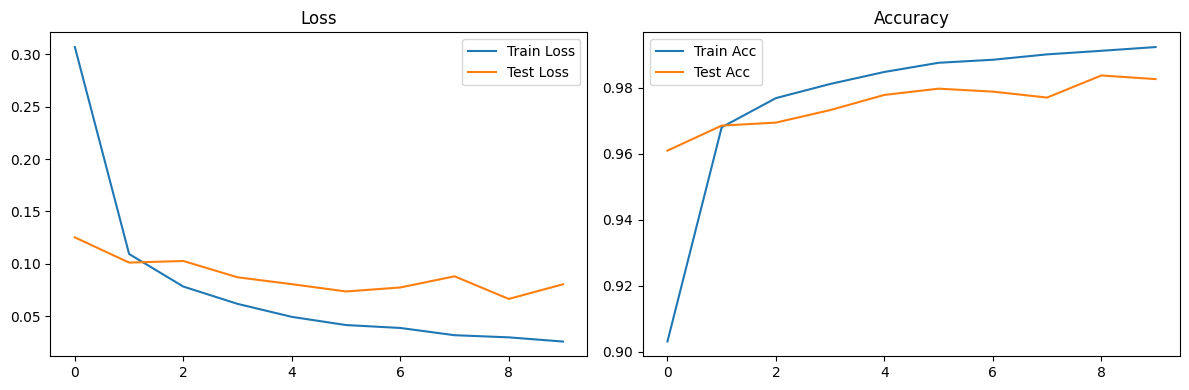

In [42]:
model = FullyConnectedModel(config_path=None, **config_7_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Зря судя по всему я не сразу отключил Dropout и BatchNorm. Так как без них крайне сильно заметно их влияние на качество моделей. Во всех моделей переобучение заметна прям сразу.

# Датасет с RGB изображением
config взял прежний, с Dropout и BatchNorm
Также нужно изменить количество входных нейронов, так как в данном датасете используется изображения большей размерности

In [45]:
config_1_layer = {
    "input_size": 3072,
    "num_classes": 10,
    "layers": []
}

config_2_layer = {
    "input_size": 3072,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
    ]
}

config_3_layer = {
    "input_size": 3072,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
    ]
}

config_5_layer = {
    "input_size": 3072,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "linear", "size": 128},
        {"type": "relu"},
        {"type": "linear", "size": 64},
        {"type": "relu"},
    ]
}

config_7_layer = {
    "input_size": 3072,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "linear", "size": 128},
        {"type": "relu"},
        {"type": "linear", "size": 64},
        {"type": "relu"},
        {"type": "linear", "size": 32},
        {"type": "relu"},
    ]
}


1

Model parameters: 30730


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 26.04it/s]


Epoch 1/10:
Train Loss: 2.0392, Train Acc: 0.3327
Test Loss: 2.0224, Test Acc: 0.3301
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.71it/s]


Epoch 2/10:
Train Loss: 1.9792, Train Acc: 0.3540
Test Loss: 2.0505, Test Acc: 0.3267
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.21it/s]


Epoch 3/10:
Train Loss: 1.9603, Train Acc: 0.3626
Test Loss: 2.0314, Test Acc: 0.3290
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.26it/s]


Epoch 4/10:
Train Loss: 1.9342, Train Acc: 0.3676
Test Loss: 1.9781, Test Acc: 0.3445
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.39it/s]


Epoch 5/10:
Train Loss: 1.9292, Train Acc: 0.3718
Test Loss: 1.9567, Test Acc: 0.3637
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.39it/s]


Epoch 6/10:
Train Loss: 1.9228, Train Acc: 0.3745
Test Loss: 2.0887, Test Acc: 0.3495
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.76it/s]


Epoch 7/10:
Train Loss: 1.9101, Train Acc: 0.3767
Test Loss: 2.0919, Test Acc: 0.3319
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.66it/s]


Epoch 8/10:
Train Loss: 1.9049, Train Acc: 0.3775
Test Loss: 2.0590, Test Acc: 0.3386
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.15it/s]


Epoch 9/10:
Train Loss: 1.9331, Train Acc: 0.3767
Test Loss: 2.1001, Test Acc: 0.3239
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.22it/s]


Epoch 10/10:
Train Loss: 1.9040, Train Acc: 0.3800
Test Loss: 2.0792, Test Acc: 0.3399
--------------------------------------------------
{'train_losses': [2.039212312844708, 1.9791968457229303, 1.9602915126344431, 1.9342051386223424, 1.929222736059857, 1.9227824086118537, 1.9100786330145034, 1.9048569478342294, 1.9331082849551344, 1.9040188132344609], 'train_accs': [0.33274, 0.35396, 0.36256, 0.36756, 0.37182, 0.37452, 0.3767, 0.37754, 0.3767, 0.38], 'test_losses': [2.0224050199909573, 2.0505021096794467, 2.0313691045068634, 1.9781035480985216, 1.9566804375618128, 2.088671476218351, 2.091908987160701, 2.0590279216219667, 2.1001276377659694, 2.079151981955121], 'test_accs': [0.3301, 0.3267, 0.329, 0.3445, 0.3637, 0.3495, 0.3319, 0.3386, 0.3239, 0.3399]}
349.9864797592163


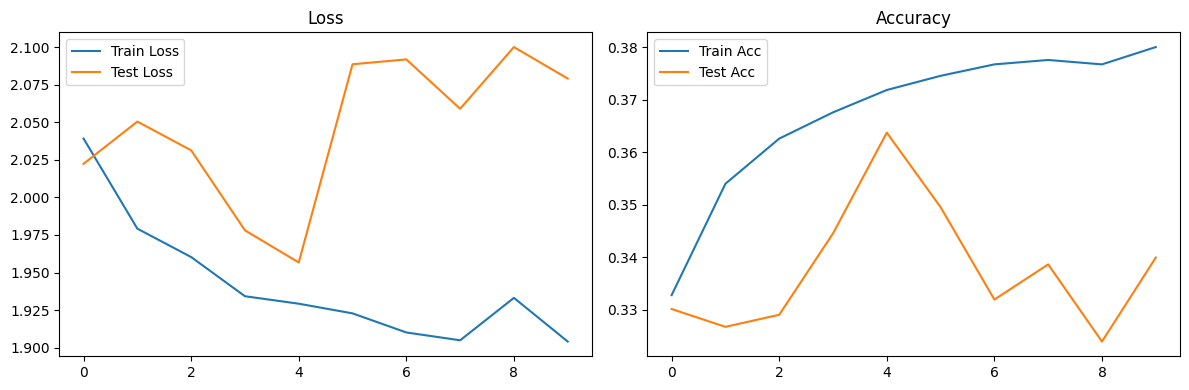

In [46]:
train_loader, test_loader = get_cifar_loaders(batch_size=64)

#Выбираем один из наборов конфигураций модели
model = FullyConnectedModel(config_path=None, **config_1_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

2

Model parameters: 1578506


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.20it/s]


Epoch 1/10:
Train Loss: 1.7532, Train Acc: 0.4066
Test Loss: 1.5892, Test Acc: 0.4456
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.34it/s]


Epoch 2/10:
Train Loss: 1.5572, Train Acc: 0.4672
Test Loss: 1.6126, Test Acc: 0.4546
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 26.00it/s]


Epoch 3/10:
Train Loss: 1.4887, Train Acc: 0.4961
Test Loss: 1.6646, Test Acc: 0.4617
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.64it/s]


Epoch 4/10:
Train Loss: 1.4235, Train Acc: 0.5187
Test Loss: 1.6073, Test Acc: 0.4782
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.49it/s]


Epoch 5/10:
Train Loss: 1.3762, Train Acc: 0.5375
Test Loss: 1.5607, Test Acc: 0.4928
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 19.94it/s]


Epoch 6/10:
Train Loss: 1.3225, Train Acc: 0.5575
Test Loss: 1.6218, Test Acc: 0.4756
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.87it/s]


Epoch 7/10:
Train Loss: 1.2751, Train Acc: 0.5766
Test Loss: 1.6183, Test Acc: 0.4879
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 19.34it/s]


Epoch 8/10:
Train Loss: 1.2356, Train Acc: 0.5923
Test Loss: 1.6381, Test Acc: 0.4971
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.14it/s]


Epoch 9/10:
Train Loss: 1.1898, Train Acc: 0.6079
Test Loss: 1.5993, Test Acc: 0.5128
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.32it/s]


Epoch 10/10:
Train Loss: 1.1550, Train Acc: 0.6191
Test Loss: 1.7055, Test Acc: 0.4970
--------------------------------------------------
{'train_losses': [1.753223140068981, 1.5572103528720338, 1.488665151474116, 1.4234698200622178, 1.376192954190247, 1.3224594133436833, 1.2750852795513086, 1.2355641350721764, 1.1898372577279426, 1.1550438820248674], 'train_accs': [0.40658, 0.46722, 0.49612, 0.51866, 0.53748, 0.55746, 0.5766, 0.59228, 0.60786, 0.61912], 'test_losses': [1.5891876699058873, 1.6125574635851914, 1.6646219021195818, 1.6072862284957983, 1.560749335653463, 1.621793466768447, 1.6182535324886347, 1.6380568332732863, 1.5993377608098802, 1.7054846021020489], 'test_accs': [0.4456, 0.4546, 0.4617, 0.4782, 0.4928, 0.4756, 0.4879, 0.4971, 0.5128, 0.497]}
598.3064136505127


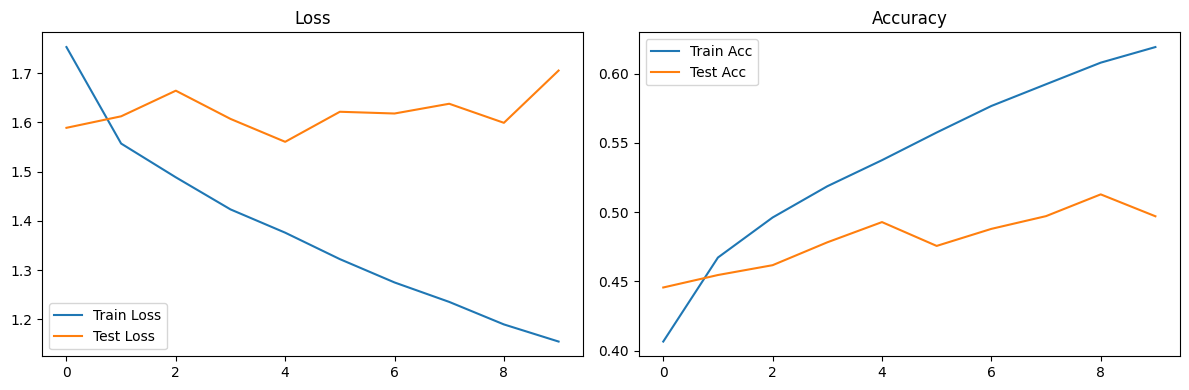

In [47]:
model = FullyConnectedModel(config_path=None, **config_2_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

3

Model parameters: 1707274


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.73it/s]


Epoch 1/10:
Train Loss: 1.6585, Train Acc: 0.4158
Test Loss: 1.5255, Test Acc: 0.4559
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.75it/s]


Epoch 2/10:
Train Loss: 1.4712, Train Acc: 0.4792
Test Loss: 1.5070, Test Acc: 0.4677
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.91it/s]


Epoch 3/10:
Train Loss: 1.3724, Train Acc: 0.5154
Test Loss: 1.4479, Test Acc: 0.4992
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.77it/s]


Epoch 4/10:
Train Loss: 1.2926, Train Acc: 0.5434
Test Loss: 1.4725, Test Acc: 0.4928
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.96it/s]


Epoch 5/10:
Train Loss: 1.2262, Train Acc: 0.5683
Test Loss: 1.4386, Test Acc: 0.5119
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.17it/s]


Epoch 6/10:
Train Loss: 1.1616, Train Acc: 0.5894
Test Loss: 1.4081, Test Acc: 0.5163
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 17.04it/s]


Epoch 7/10:
Train Loss: 1.0949, Train Acc: 0.6119
Test Loss: 1.4182, Test Acc: 0.5222
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.48it/s]


Epoch 8/10:
Train Loss: 1.0386, Train Acc: 0.6319
Test Loss: 1.4526, Test Acc: 0.5267
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.58it/s]


Epoch 9/10:
Train Loss: 0.9843, Train Acc: 0.6508
Test Loss: 1.5200, Test Acc: 0.5259
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.42it/s]


Epoch 10/10:
Train Loss: 0.9382, Train Acc: 0.6673
Test Loss: 1.4956, Test Acc: 0.5239
--------------------------------------------------
{'train_losses': [1.6584842634932768, 1.471230408572175, 1.3723533812081417, 1.2926102295098707, 1.226248086108576, 1.1615534279200121, 1.0948648417697233, 1.0385755688485587, 0.9842789955913563, 0.9381684247032761], 'train_accs': [0.41578, 0.47924, 0.5154, 0.54342, 0.5683, 0.58938, 0.6119, 0.6319, 0.65082, 0.66728], 'test_losses': [1.5254961548337511, 1.506968060116859, 1.4478689804198637, 1.4725210932409687, 1.4385927057569954, 1.4080633957674549, 1.4181571526891867, 1.4526005205075452, 1.5199650575400918, 1.4955526799153371], 'test_accs': [0.4559, 0.4677, 0.4992, 0.4928, 0.5119, 0.5163, 0.5222, 0.5267, 0.5259, 0.5239]}
586.2629072666168


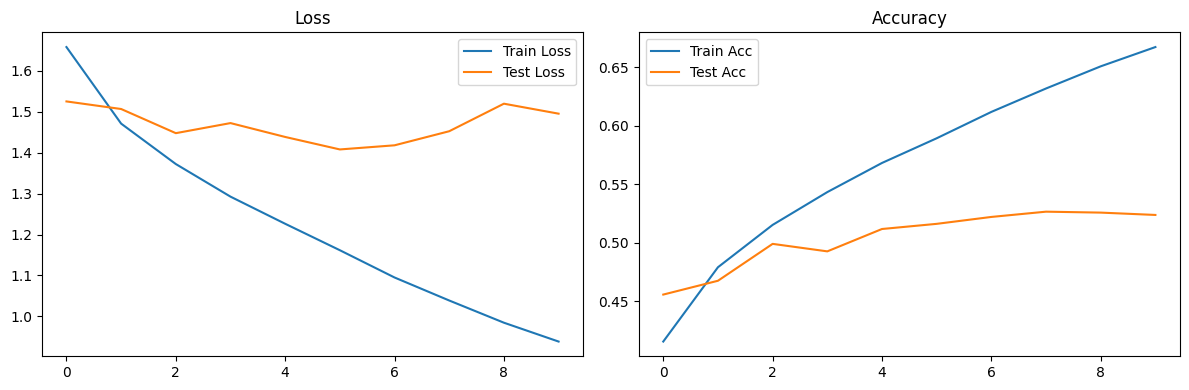

In [48]:
model = FullyConnectedModel(config_path=None, **config_3_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

5

Model parameters: 1746506


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.89it/s]


Epoch 1/10:
Train Loss: 1.6861, Train Acc: 0.3959
Test Loss: 1.5493, Test Acc: 0.4510
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.37it/s]


Epoch 2/10:
Train Loss: 1.4738, Train Acc: 0.4804
Test Loss: 1.4499, Test Acc: 0.4886
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.31it/s]


Epoch 3/10:
Train Loss: 1.3593, Train Acc: 0.5195
Test Loss: 1.4161, Test Acc: 0.4984
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.16it/s]


Epoch 4/10:
Train Loss: 1.2763, Train Acc: 0.5503
Test Loss: 1.3532, Test Acc: 0.5267
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.34it/s]


Epoch 5/10:
Train Loss: 1.1907, Train Acc: 0.5785
Test Loss: 1.3753, Test Acc: 0.5241
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.92it/s]


Epoch 6/10:
Train Loss: 1.1240, Train Acc: 0.6010
Test Loss: 1.3793, Test Acc: 0.5269
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 20.54it/s]


Epoch 7/10:
Train Loss: 1.0544, Train Acc: 0.6266
Test Loss: 1.3616, Test Acc: 0.5409
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.55it/s]


Epoch 8/10:
Train Loss: 0.9952, Train Acc: 0.6494
Test Loss: 1.4236, Test Acc: 0.5373
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.46it/s]


Epoch 9/10:
Train Loss: 0.9353, Train Acc: 0.6676
Test Loss: 1.4566, Test Acc: 0.5287
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.26it/s]


Epoch 10/10:
Train Loss: 0.8808, Train Acc: 0.6842
Test Loss: 1.4593, Test Acc: 0.5361
--------------------------------------------------
{'train_losses': [1.6860535926831044, 1.4737920244331555, 1.359283251225796, 1.276320585280733, 1.1906981525366263, 1.124012620019181, 1.0544132530841681, 0.9952117831200895, 0.935283747627912, 0.8807745001962423], 'train_accs': [0.39594, 0.4804, 0.51954, 0.55026, 0.57848, 0.601, 0.62656, 0.64936, 0.66764, 0.68422], 'test_losses': [1.5493394144021781, 1.4499137424359656, 1.4161470361575959, 1.3531837326705836, 1.3753429814508766, 1.3793144841103038, 1.3615715754259923, 1.4236490878329915, 1.4565534048778996, 1.4593230167012305], 'test_accs': [0.451, 0.4886, 0.4984, 0.5267, 0.5241, 0.5269, 0.5409, 0.5373, 0.5287, 0.5361]}
542.9050962924957


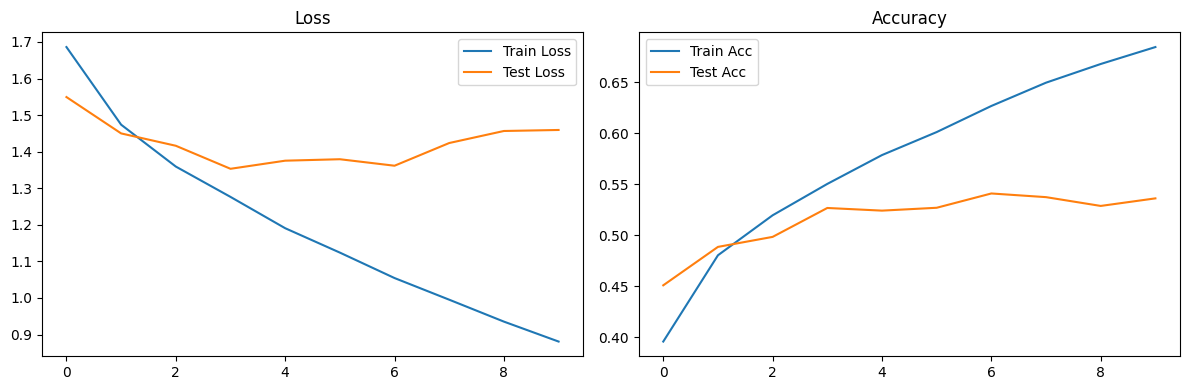

In [49]:
model = FullyConnectedModel(config_path=None, **config_5_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

7

Model parameters: 1748266


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.91it/s]


Epoch 1/10:
Train Loss: 1.7167, Train Acc: 0.3897
Test Loss: 1.5351, Test Acc: 0.4527
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.69it/s]


Epoch 2/10:
Train Loss: 1.4897, Train Acc: 0.4752
Test Loss: 1.4326, Test Acc: 0.4903
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.04it/s]


Epoch 3/10:
Train Loss: 1.3702, Train Acc: 0.5187
Test Loss: 1.4110, Test Acc: 0.5000
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.36it/s]


Epoch 4/10:
Train Loss: 1.2815, Train Acc: 0.5483
Test Loss: 1.3794, Test Acc: 0.5214
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.12it/s]


Epoch 5/10:
Train Loss: 1.2030, Train Acc: 0.5748
Test Loss: 1.3595, Test Acc: 0.5335
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.53it/s]


Epoch 6/10:
Train Loss: 1.1271, Train Acc: 0.6031
Test Loss: 1.3800, Test Acc: 0.5264
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.50it/s]


Epoch 7/10:
Train Loss: 1.0613, Train Acc: 0.6246
Test Loss: 1.3566, Test Acc: 0.5400
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.80it/s]


Epoch 8/10:
Train Loss: 0.9896, Train Acc: 0.6472
Test Loss: 1.4175, Test Acc: 0.5348
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.80it/s]


Epoch 9/10:
Train Loss: 0.9363, Train Acc: 0.6669
Test Loss: 1.4422, Test Acc: 0.5314
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.22it/s]


Epoch 10/10:
Train Loss: 0.8869, Train Acc: 0.6855
Test Loss: 1.4475, Test Acc: 0.5388
--------------------------------------------------
{'train_losses': [1.7167262840453925, 1.4897432723618529, 1.3701892841197645, 1.2814810269171624, 1.2030308511098633, 1.1271030665815944, 1.061263394172844, 0.9896399298744738, 0.936309345619148, 0.8868892590713013], 'train_accs': [0.38966, 0.47518, 0.51872, 0.54832, 0.57476, 0.6031, 0.62464, 0.64716, 0.66686, 0.68552], 'test_losses': [1.5350762689189545, 1.4326194669031034, 1.4110236213465406, 1.3794463022499328, 1.3594902226120045, 1.3800286851870787, 1.3566002526860328, 1.4175152672324212, 1.4421949515676802, 1.4474895406680501], 'test_accs': [0.4527, 0.4903, 0.5, 0.5214, 0.5335, 0.5264, 0.54, 0.5348, 0.5314, 0.5388]}
524.5219256877899


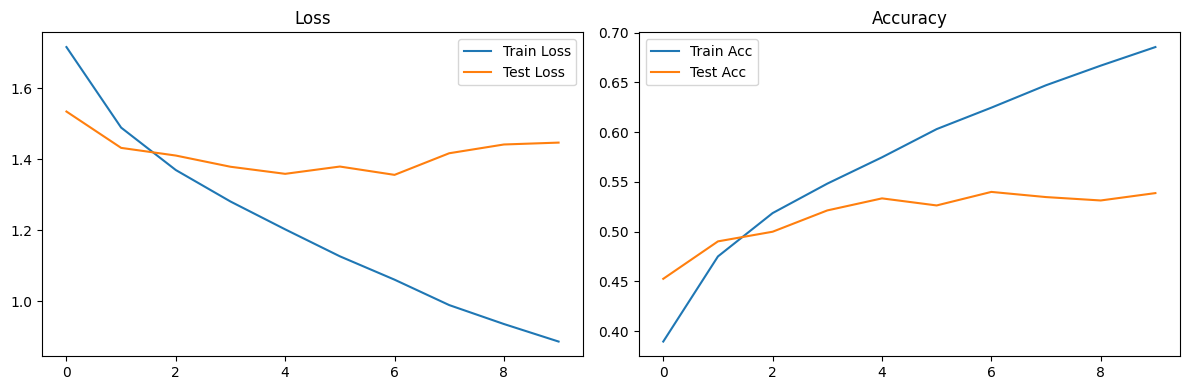

In [50]:
model = FullyConnectedModel(config_path=None, **config_7_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

# Итог пункта 1 

У датасета CIFAR все печально, модели явно плохо обучились (Особенно модель с 1 слоем). Ошибка растет, но есть хотя бы и плюс, accuracy тоже растет у большинства моделей.

Для большинства моделей, качество параметров начинает падать на 8-ой эпохе у MNIST, и для CIFAR на 4-ой эпохе

Для датасета MINST лучше всего 1 слой и 7 слоев.

Для датасета CIFAR лучше всего 7 слоев